In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#load generator data
gds = {}
gds[2019] = pickle.load(open('Data/generator_data_short_WECC_2019.obj', 'rb'))
gds[2020] = pickle.load(open('Data/generator_data_short_WECC_2020.obj', 'rb'))

colorset = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499']
'''Color list:
indigo, cyan, teal, green, sand, rose, wine, olive, purple
uncontrolled, color = colorset[0], '-*'
mef normal all access, color = colorset[4], '-X'
mef normal plugged, color = colorset[6]
aef all access, color = colorset[3], 
aef plugged, color = colorset[1]
mef cascade all access, color = colorset[5]
mef cascade plugged, color = colorset[8]
'''

path_string_daytime = '/Users/sonia/OneDrive - Stanford/GreenCharging_SharedResults/Daytime/'
path_string_aef = '/Users/sonia/OneDrive - Stanford/GreenCharging_SharedResults/AEF/'
path_string_cascade = '/Users/sonia/OneDrive - Stanford/GreenCharging_SharedResults/MEF_Cascade/'
path_string_daytime_2030 = '/Users/sonia/OneDrive - Stanford/GreenCharging_SharedResults/Daytime_2030/'
path_string_aef_2030 = '/Users/sonia/OneDrive - Stanford/GreenCharging_SharedResults/AEF_2030/'
path_string_cascade_2030 = '/Users/sonia/OneDrive - Stanford/GreenCharging_SharedResults/MEF_2030_Cascade/'
result_dates = ['20231207']

In [2]:
def results_gperkwh_fxn_avg(numev_set, path_string, run_numbers, result_date, current_year = None, month=1):
    '''Function to calculate average g/kWh for each run number and number of EVs added'''
    if current_year == 2030:
        #use 2020 for uncontrolled data
        dpdf_year = '2020'
        #get reference baseline projected 2030 demand

        reference_df = pd.read_csv('Results/' +'2030_dpdf_'+'20220522'+ '.csv')

    #default = 2020
    else:
        dpdf_year = '2020'
        reference_df = pd.read_csv('Results/2020_dpdf_20220522.csv')

    if month == 1:
        time_period_string = '2020-01-01_to_2020-01-31'
    elif month == 7: 
        time_period_string = '2020-07-01_to_2020-07-31'

    results_gperkwh_avg = pd.DataFrame(index=numev_set, columns=['uncontrolled', 'uncontrolled_2s', 'varying_access', 'varying_plugged', 'varying_access_2s', 'varying_plugged_2s'])
    for num_evs in numev_set:
        results_gperkwh = pd.DataFrame(index=run_numbers, columns=['uncontrolled', 'varying_access', 'varying_plugged'])
        for run_number in run_numbers:
            df_total_uncontrolled = {}; df_uncontrolled_dpdf = {}
            df_controlled_dpdf = {'varying':{'access':{}, 'plugged':{}}}
            df_total_controlled = { 'varying':{'access':{}, 'plugged':{}}}
    
            #save uncontrolled demand data in df
            df_total_uncontrolled[num_evs] = pd.read_csv(path_string + str(num_evs)+'EVs_added/Uncontrolled/demand_run'+run_number+'_'+time_period_string+'_'+result_date+'.csv', index_col=0)
            
            df_total_uncontrolled[num_evs].datetime = pd.to_datetime(df_total_uncontrolled[num_evs].datetime)
            df_uncontrolled_dpdf[num_evs] = pd.read_csv(path_string +str(num_evs)+'EVs_added/Uncontrolled/results_'+dpdf_year+'_run'+run_number+'_'+time_period_string+'_dpdf_'+result_date+'.csv')
            df_uncontrolled_dpdf[num_evs].datetime = pd.to_datetime(df_uncontrolled_dpdf[num_evs].datetime)
            
            for signal1 in ['varying']:
                try: #if have both plugged and access saved
                    for signal2 in ['access', 'plugged']:
                        df_total_controlled[signal1][signal2][num_evs] = pd.read_csv(path_string +str(num_evs)+'EVs_added/Controlled_'+str(signal1)+'_allaccess_'+str(signal2)+'_series/demand_run'+run_number+'_'+time_period_string+'_'+result_date+'.csv', index_col=0)
                        df_total_controlled[signal1][signal2][num_evs].datetime = pd.to_datetime(df_total_controlled[signal1][signal2][num_evs].datetime)
                        df_controlled_dpdf[signal1][signal2][num_evs] = pd.read_csv(path_string+str(num_evs)+'EVs_added/Controlled_'+str(signal1)+'_allaccess_'+str(signal2)+'_series/results_'+dpdf_year+'_run'+run_number+'_'+time_period_string+'_dpdf_'+result_date+'.csv')
                        df_controlled_dpdf[signal1][signal2][num_evs].datetime = pd.to_datetime(df_controlled_dpdf[signal1][signal2][num_evs].datetime)
                except: #if don't have plugged and access saved
                    try:
                        for signal2 in ['access']:
                            df_total_controlled[signal1][signal2][num_evs] = pd.read_csv(path_string +str(num_evs)+'EVs_added/Controlled_'+str(signal1)+'_allaccess_'+str(signal2)+'_series/demand_run'+run_number+'_'+time_period_string+'_'+result_date+'.csv', index_col=0)
                            df_total_controlled[signal1][signal2][num_evs].datetime = pd.to_datetime(df_total_controlled[signal1][signal2][num_evs].datetime)
                            df_controlled_dpdf[signal1][signal2][num_evs] = pd.read_csv(path_string+str(num_evs)+'EVs_added/Controlled_'+str(signal1)+'_allaccess_'+str(signal2)+'_series/results_'+dpdf_year+'_run'+run_number+'_'+time_period_string+'_dpdf_'+result_date+'.csv')
                            df_controlled_dpdf[signal1][signal2][num_evs].datetime = pd.to_datetime(df_controlled_dpdf[signal1][signal2][num_evs].datetime)
                    except:
                        for signal2 in ['plugged']:
                            df_total_controlled[signal1][signal2][num_evs] = pd.read_csv(path_string +str(num_evs)+'EVs_added/Controlled_'+str(signal1)+'_allaccess_'+str(signal2)+'_series/demand_run'+run_number+'_'+time_period_string+'_'+result_date+'.csv', index_col=0)
                            df_total_controlled[signal1][signal2][num_evs].datetime = pd.to_datetime(df_total_controlled[signal1][signal2][num_evs].datetime)
                            df_controlled_dpdf[signal1][signal2][num_evs] = pd.read_csv(path_string+str(num_evs)+'EVs_added/Controlled_'+str(signal1)+'_allaccess_'+str(signal2)+'_series/results_'+dpdf_year+'_run'+run_number+'_'+time_period_string+'_dpdf_'+result_date+'.csv')
                            df_controlled_dpdf[signal1][signal2][num_evs].datetime = pd.to_datetime(df_controlled_dpdf[signal1][signal2][num_evs].datetime)

            #find dates to plot (inds)
            signal1 = 'varying'
            signal2 = 'access'
            try:
                dpdf_inds = df_uncontrolled_dpdf[num_evs][df_uncontrolled_dpdf[num_evs].datetime.dt.date.isin(df_total_controlled[signal1][signal2][num_evs].datetime.dt.date.unique())].index
            except:
                signal2 = 'plugged'
                dpdf_inds = df_uncontrolled_dpdf[num_evs][df_uncontrolled_dpdf[num_evs].datetime.dt.date.isin(df_total_controlled[signal1][signal2][num_evs].datetime.dt.date.unique())].index

            delta_co2 = df_uncontrolled_dpdf[num_evs].loc[dpdf_inds, 'co2_tot'].sum() - reference_df.loc[dpdf_inds, 'co2_tot'].sum()
            delta_demand = df_uncontrolled_dpdf[num_evs].loc[dpdf_inds, 'demand'].sum() - reference_df.loc[dpdf_inds, 'demand'].sum()
            #print(num_evs, run_number, delta_co2)
            #print(num_evs, run_number, delta_demand)

            
            results_gperkwh.loc[run_number, 'uncontrolled'] = delta_co2/delta_demand
            
            signal1 = 'varying'
            signal2_set = ['access', 'plugged']
            try:
                for signal2 in signal2_set:
                    delta_co2 = df_controlled_dpdf[signal1][signal2][num_evs].loc[dpdf_inds, 'co2_tot'].sum() - reference_df.loc[dpdf_inds, 'co2_tot'].sum()
                    delta_demand = df_controlled_dpdf[signal1][signal2][num_evs].loc[dpdf_inds, 'demand'].sum() - reference_df.loc[dpdf_inds, 'demand'].sum()
                    results_gperkwh.loc[run_number, signal1+'_'+signal2] = delta_co2/delta_demand
            except:
                try:
                    for signal2 in ['access']:
                        delta_co2 = df_controlled_dpdf[signal1][signal2][num_evs].loc[dpdf_inds, 'co2_tot'].sum() - reference_df.loc[dpdf_inds, 'co2_tot'].sum()
                        delta_demand = df_controlled_dpdf[signal1][signal2][num_evs].loc[dpdf_inds, 'demand'].sum() - reference_df.loc[dpdf_inds, 'demand'].sum()
                        results_gperkwh.loc[run_number, signal1+'_'+signal2] = delta_co2/delta_demand
                except:
                    for signal2 in ['plugged']:
                        delta_co2 = df_controlled_dpdf[signal1][signal2][num_evs].loc[dpdf_inds, 'co2_tot'].sum() - reference_df.loc[dpdf_inds, 'co2_tot'].sum()
                        delta_demand = df_controlled_dpdf[signal1][signal2][num_evs].loc[dpdf_inds, 'demand'].sum() - reference_df.loc[dpdf_inds, 'demand'].sum()
                        results_gperkwh.loc[run_number, signal1+'_'+signal2] = delta_co2/delta_demand

        results_gperkwh_avg.loc[num_evs, 'uncontrolled'] = np.average(results_gperkwh.loc[:, 'uncontrolled'])
        results_gperkwh_avg.loc[num_evs, 'varying_access'] = np.nanmean(results_gperkwh.loc[:, 'varying_access'])
        results_gperkwh_avg.loc[num_evs, 'varying_plugged'] = np.nanmean(results_gperkwh.loc[:, 'varying_plugged'])
        results_gperkwh_avg.loc[num_evs, 'uncontrolled_2s'] = 2 * np.std(results_gperkwh.loc[:, 'uncontrolled'])
        results_gperkwh_avg.loc[num_evs, 'varying_access_2s'] = 2 * np.std(results_gperkwh.loc[:, 'varying_access'])
        results_gperkwh_avg.loc[num_evs, 'varying_plugged_2s'] = 2 * np.std(results_gperkwh.loc[:, 'varying_plugged'])

    return results_gperkwh_avg

In [3]:
def multi_run_plot(numev_set, results_gperkwh, results_gperkwh_aef, results_cascade, fig, axes, year2030=False, aef=False, title=False, save_name='totalemissions_adding_evs', to_plot = [0], cascade_2 = None, max_lim=725, legend_pos = 'lower right'):

    xvals = numev_set
    #uncontrolled, color = colorset[0]
    #mef normal all access, color = colorset[4]
    #mef normal plugged, color = colorset[6]
    #aef all access, color = colorset[3]
    #aef plugged, color = colorset[1]
    #mef cascade all access, color = colorset[5]
    #mef cascade plugged, color = colorset[8]

    if np.sum(np.isin(0, to_plot)): # uncontrolled
        axes.plot(xvals, results_gperkwh.uncontrolled, '*', label='Uncontrolled', color = colorset[0], markersize=18)
        axes.fill_between(xvals, np.array(results_gperkwh.uncontrolled - results_gperkwh.uncontrolled_2s, dtype=float), np.array(results_gperkwh.uncontrolled + results_gperkwh.uncontrolled_2s, dtype=float), alpha=0.6, linewidth=.6,color = colorset[0])
    
    if np.sum(np.isin(1, to_plot)): #daytime max sessions
        axes.plot(xvals, results_gperkwh.varying_access, 'X', label='Daytime, Max. Sessions', color=colorset[7], markersize=11)
        axes.fill_between(xvals, np.array(results_gperkwh.varying_access - results_gperkwh.varying_access_2s, dtype=float), np.array(results_gperkwh.varying_access + results_gperkwh.varying_access_2s, dtype=float), alpha=0.6, linewidth=.6,color = colorset[7])
    
    if np.sum(np.isin(2, to_plot)): #dayime existing sessions
        axes.plot(xvals, results_gperkwh.varying_plugged, 'o', label='Daytime, Existing Sessions', color=colorset[7], markersize=13)
        axes.fill_between(xvals, np.array(results_gperkwh.varying_plugged - results_gperkwh.varying_plugged_2s, dtype=float), np.array(results_gperkwh.varying_plugged + results_gperkwh.varying_plugged_2s, dtype=float), alpha=0.6, linewidth=.6,color = colorset[7])

    if np.sum(np.isin(3, to_plot)): #aef max sessions
        axes.plot(xvals, results_gperkwh_aef.varying_access, 's',  label='AEF, Max. Sessions', color=colorset[3], markersize=13)
        axes.fill_between(xvals, np.array(results_gperkwh_aef.varying_access - results_gperkwh_aef.varying_access_2s, dtype=float), np.array(results_gperkwh_aef.varying_access + results_gperkwh_aef.varying_access_2s, dtype=float), alpha=0.6, linewidth=.6, color = colorset[3])
    
    if np.sum(np.isin(4, to_plot)): #aef existing sessions
        axes.plot(xvals, results_gperkwh_aef.varying_plugged, 'P',  label='AEF, Existing Sessions', color=colorset[1], markersize=14)
        axes.fill_between(xvals, np.array(results_gperkwh_aef.varying_plugged - results_gperkwh_aef.varying_plugged_2s, dtype=float), np.array(results_gperkwh_aef.varying_plugged + results_gperkwh_aef.varying_plugged_2s, dtype=float), alpha=0.6, linewidth=.6, color = colorset[1])


    if cascade_2 is None:
        if np.sum(np.isin(5, to_plot)): #mef cascade all access 20 groups
            axes.plot(xvals, results_cascade.varying_access, 'd', label='Cascading MEF, Max. Sessions', color = colorset[5], markersize=14)
            axes.fill_between(xvals, np.array(results_cascade.varying_access - results_cascade.varying_access_2s, dtype=float), np.array(results_cascade.varying_access + results_cascade.varying_access_2s, dtype=float), alpha=0.6, linewidth=.6, color = colorset[5])

        if np.sum(np.isin(6, to_plot)): #mef cascade plugged 20 groups
            axes.plot(xvals, results_cascade.varying_plugged, 'H', label='Cascading MEF, Existing Sessions', color = colorset[8], markersize=14)
            axes.fill_between(xvals, np.array(results_cascade.varying_plugged - results_cascade.varying_plugged_2s, dtype=float), np.array(results_cascade.varying_plugged + results_cascade.varying_plugged_2s, dtype=float),alpha=0.6, linewidth=.6, color = colorset[8])

   

    axes.set_xlim([-100000,numev_set[-1]+100000])
    axes.set_xticks(np.linspace(0,numev_set[-1],5))
    axes.set_xticklabels(np.linspace(0, numev_set[-1], 5, dtype=int), fontsize=16)

    axes.set_xlabel('Number of EVs Added', fontsize=18)
   
    axes.set_yticks(np.arange(400, max_lim, 50))
    axes.set_yticklabels(np.arange(400, max_lim, 50), fontsize=18)
    axes.set_ylabel('Added CO$_2$ Emissions [kg/MWh]', fontsize=18)
    axes.legend(fontsize=13.5, loc=4)
    
    axes.legend(fontsize=14.5, loc=legend_pos)
    axes.grid(axis='y')
    if title:
        pass

    plt.tight_layout()
    plt.savefig('Added_Emissions/'+save_name+'.pdf', bbox_inches='tight')
    plt.show()
    return 
    

# a

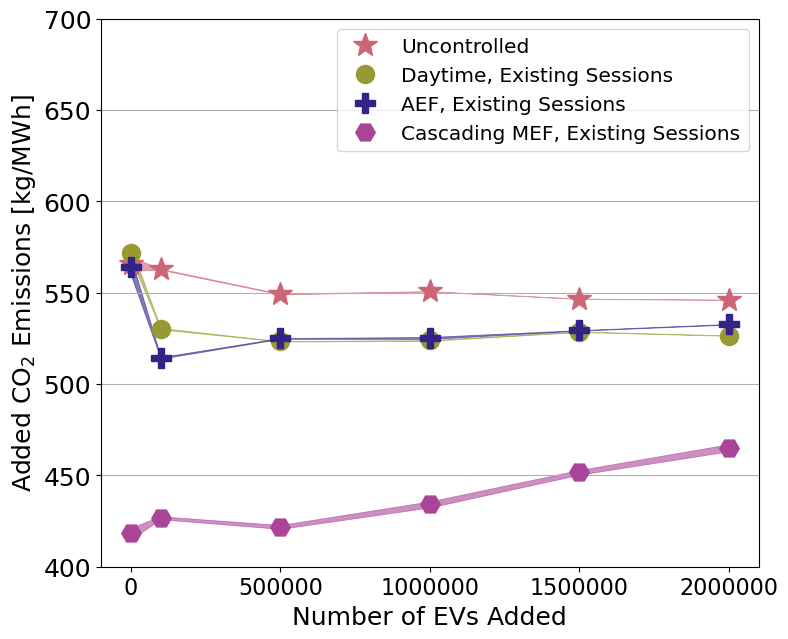

In [4]:
#run custom added emissions plot

run_nums = [str(i) for i in range(15)]

added_EVs = [1000,100000, 500000, 1000000, 1500000, 2000000]
fig1, axes1 = plt.subplots(figsize=(8,6.5))
  

#get daytime
results_gperkwh = results_gperkwh_fxn_avg(added_EVs, path_string_daytime, run_nums, result_dates[0])

#get regular AEF
results_gperkwh_aef = results_gperkwh_fxn_avg(added_EVs, path_string_aef, run_nums, result_dates[0])

#get cascade
results_cascade = results_gperkwh_fxn_avg(added_EVs, path_string_cascade, run_nums, result_dates[0])

multi_run_plot(added_EVs, results_gperkwh, results_gperkwh_aef, results_cascade, fig1, axes1,  save_name='S3a_added_emissions_jan_20_exist', to_plot = [0,2,4,6], legend_pos='upper right') 

In [5]:
## print table:
print('Number of Vehicles & Uncontrolled & Controlled: Daytime  \hline' + '\\'+ '\\')
print('1,000      & '+ str(np.round(results_gperkwh.uncontrolled[1000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[1000],1)) +'\\' + '\\')
print('100,000    & '+ str(np.round(results_gperkwh.uncontrolled[100000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[100000],1)) +'\\' + '\\')
print('500,000    & '+ str(np.round(results_gperkwh.uncontrolled[500000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[500000],1))+ '\\' + '\\')
print('1,000,000  & '+ str(np.round(results_gperkwh.uncontrolled[1000000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[1000000],1)) +'\\' + '\\')
print('1,500,000  & '+ str(np.round(results_gperkwh.uncontrolled[1500000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[1500000],1))+ '\\' + '\\')
print('2,000,000  & '+ str(np.round(results_gperkwh.uncontrolled[2000000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[2000000],1))  +'\\' + '\\')


Number of Vehicles & Uncontrolled & Controlled: Daytime  \hline\\
1,000      & 565.8 & 571.7\\
100,000    & 562.8 & 530.3\\
500,000    & 549.2 & 523.3\\
1,000,000  & 550.7 & 523.8\\
1,500,000  & 546.6 & 528.6\\
2,000,000  & 546.1 & 526.5\\


# b

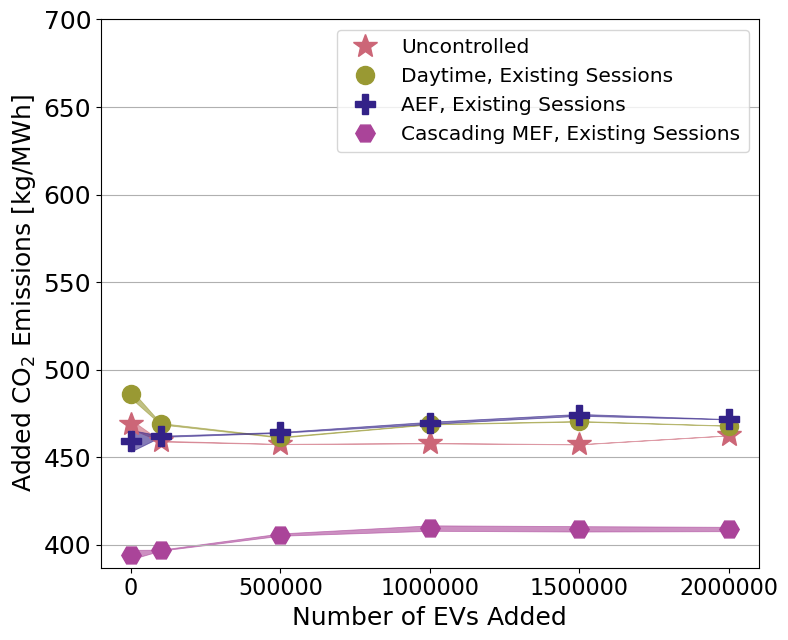

In [6]:
# run custom main plot - 2030

run_nums = [str(i) for i in range(15)]

added_EVs = [1000, 100000, 500000, 1000000, 1500000, 2000000]
fig1, axes1 = plt.subplots(figsize=(8,6.5))

#get daytime
result_dates = ['20231207']
results_gperkwh = results_gperkwh_fxn_avg(added_EVs, path_string_daytime_2030, run_nums, result_dates[0], current_year=2030)

#get regular AEF
results_gperkwh_aef = results_gperkwh_fxn_avg(added_EVs, path_string_aef_2030, run_nums, result_dates[0], current_year=2030)

#get cascade
results_cascade = results_gperkwh_fxn_avg(added_EVs, path_string_cascade_2030, run_nums, result_dates[0], current_year=2030)

multi_run_plot(added_EVs, results_gperkwh, results_gperkwh_aef, results_cascade, fig1, axes1,  save_name='S3b_added_emissions_jan_30_exist', to_plot = [0,2,4,6], legend_pos='upper right') # 5

In [7]:
## print table:
print('Number of Vehicles & Uncontrolled & Controlled: Daytime  \hline' + '\\'+ '\\')
print('1,000      & '+ str(np.round(results_gperkwh.uncontrolled[1000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[1000],1)) +'\\' + '\\')
print('100,000    & '+ str(np.round(results_gperkwh.uncontrolled[100000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[100000],1)) +'\\' + '\\')
print('500,000    & '+ str(np.round(results_gperkwh.uncontrolled[500000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[500000],1))+ '\\' + '\\')
print('1,000,000  & '+ str(np.round(results_gperkwh.uncontrolled[1000000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[1000000],1)) +'\\' + '\\')
print('1,500,000  & '+ str(np.round(results_gperkwh.uncontrolled[1500000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[1500000],1))+ '\\' + '\\')
print('2,000,000  & '+ str(np.round(results_gperkwh.uncontrolled[2000000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[2000000],1))  +'\\' + '\\')


Number of Vehicles & Uncontrolled & Controlled: Daytime  \hline\\
1,000      & 468.7 & 486.0\\
100,000    & 459.1 & 469.0\\
500,000    & 457.4 & 461.3\\
1,000,000  & 457.9 & 468.8\\
1,500,000  & 457.3 & 470.4\\
2,000,000  & 462.4 & 467.9\\


# c

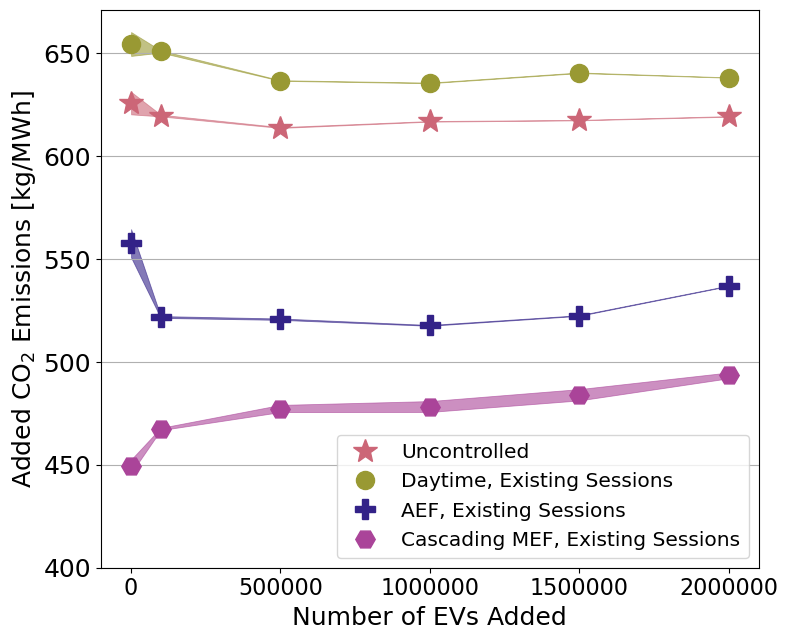

In [8]:
#run custom added emissions plot

run_nums = [str(i) for i in range(15)]

added_EVs = [1000,100000,500000, 1000000, 1500000, 2000000]
fig1, axes1 = plt.subplots(figsize=(8,6.5))

result_dates = ['20231207']
#get daytime
results_gperkwh = results_gperkwh_fxn_avg(added_EVs, path_string_daytime, run_nums, result_dates[0], month=7)

#get regular AEF
results_gperkwh_aef = results_gperkwh_fxn_avg(added_EVs, path_string_aef, run_nums, result_dates[0], month=7)

#get cascade
results_cascade = results_gperkwh_fxn_avg(added_EVs, path_string_cascade, run_nums, result_dates[0], month=7)

multi_run_plot(added_EVs, results_gperkwh, results_gperkwh_aef, results_cascade, fig1, axes1, save_name='S3c_added_emissions_jul_20_exist', to_plot = [0,2,4,6], max_lim=675) #5

In [9]:
## print table:
print('Number of Vehicles & Uncontrolled & Controlled: Daytime  \hline' + '\\'+ '\\')
print('1,000      & '+ str(np.round(results_gperkwh.uncontrolled[1000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[1000],1)) +'\\' + '\\')
print('100,000    & '+ str(np.round(results_gperkwh.uncontrolled[100000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[100000],1)) +'\\' + '\\')
print('500,000    & '+ str(np.round(results_gperkwh.uncontrolled[500000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[500000],1))+ '\\' + '\\')
print('1,000,000  & '+ str(np.round(results_gperkwh.uncontrolled[1000000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[1000000],1)) +'\\' + '\\')
print('1,500,000  & '+ str(np.round(results_gperkwh.uncontrolled[1500000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[1500000],1))+ '\\' + '\\')
print('2,000,000  & '+ str(np.round(results_gperkwh.uncontrolled[2000000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[2000000],1))  +'\\' + '\\')

Number of Vehicles & Uncontrolled & Controlled: Daytime  \hline\\
1,000      & 625.8 & 654.6\\
100,000    & 619.8 & 650.9\\
500,000    & 614.0 & 636.8\\
1,000,000  & 617.0 & 635.7\\
1,500,000  & 617.6 & 640.6\\
2,000,000  & 619.4 & 638.3\\


# d

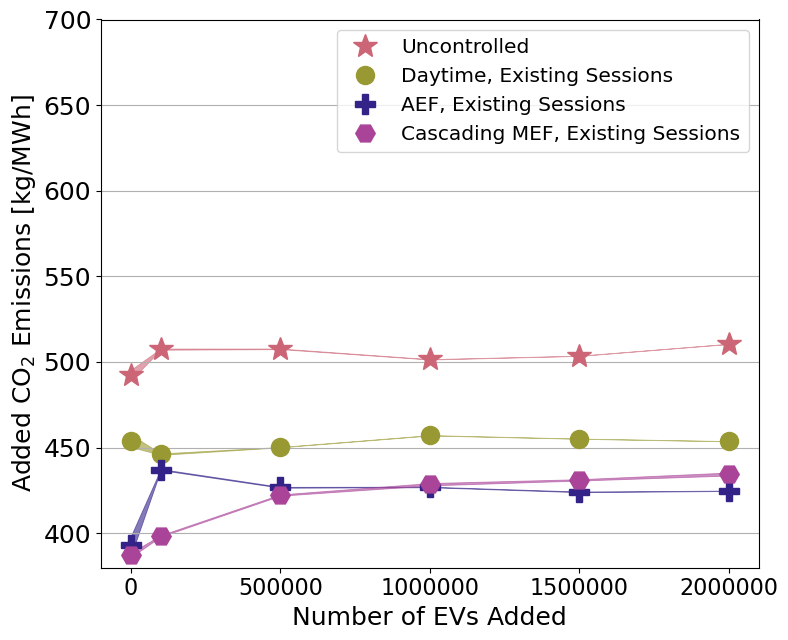

In [10]:
# run custom main plot - 2030

run_nums = [str(i) for i in range(15)]

added_EVs = [1000, 100000, 500000, 1000000, 1500000, 2000000]
fig1, axes1 = plt.subplots(figsize=(8,6.5))

#get daytime
result_dates = ['20231207']
results_gperkwh = results_gperkwh_fxn_avg(added_EVs, path_string_daytime_2030, run_nums, result_dates[0], current_year=2030, month=7)

#get regular AEF
results_gperkwh_aef = results_gperkwh_fxn_avg(added_EVs, path_string_aef_2030, run_nums, result_dates[0], current_year=2030, month=7)

#get cascade
results_cascade = results_gperkwh_fxn_avg(added_EVs, path_string_cascade_2030, run_nums, result_dates[0], current_year=2030, month=7)

multi_run_plot(added_EVs, results_gperkwh, results_gperkwh_aef, results_cascade, fig1, axes1, save_name='S3d_added_emissions_jul_30_exist', to_plot = [0,2,4,6], legend_pos='upper right') 

In [11]:
## print table:
print('Number of Vehicles & Uncontrolled & Controlled: Daytime  \hline' + '\\'+ '\\')
print('1,000      & '+ str(np.round(results_gperkwh.uncontrolled[1000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[1000],1)) +'\\' + '\\')
print('100,000    & '+ str(np.round(results_gperkwh.uncontrolled[100000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[100000],1)) +'\\' + '\\')
print('500,000    & '+ str(np.round(results_gperkwh.uncontrolled[500000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[500000],1))+ '\\' + '\\')
print('1,000,000  & '+ str(np.round(results_gperkwh.uncontrolled[1000000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[1000000],1)) +'\\' + '\\')
print('1,500,000  & '+ str(np.round(results_gperkwh.uncontrolled[1500000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[1500000],1))+ '\\' + '\\')
print('2,000,000  & '+ str(np.round(results_gperkwh.uncontrolled[2000000],1))  +' & ' + str(np.round(results_gperkwh.varying_plugged[2000000],1))  +'\\' + '\\')

Number of Vehicles & Uncontrolled & Controlled: Daytime  \hline\\
1,000      & 492.5 & 453.9\\
100,000    & 507.5 & 446.2\\
500,000    & 507.7 & 450.2\\
1,000,000  & 501.5 & 457.1\\
1,500,000  & 503.6 & 455.2\\
2,000,000  & 510.5 & 453.7\\


# e

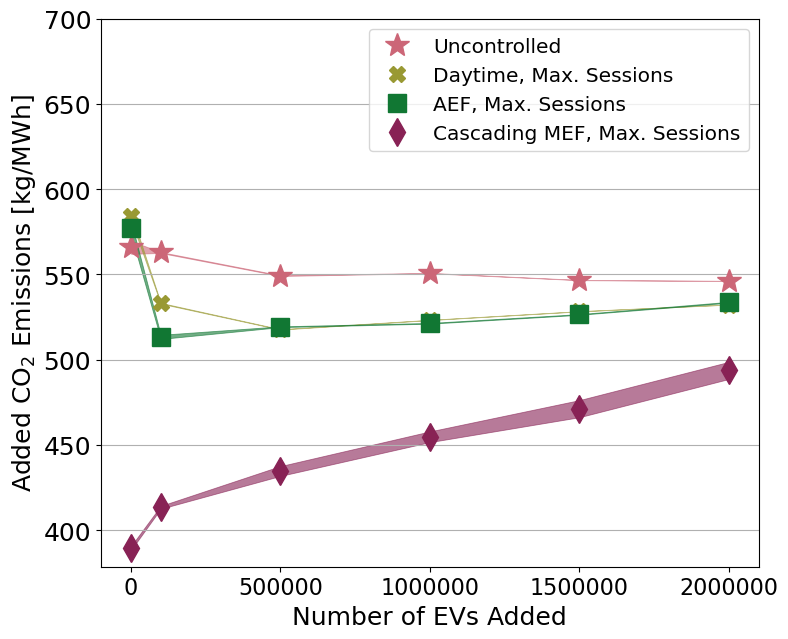

In [12]:
#run custom added emissions plot

run_nums = [str(i) for i in range(15)]

added_EVs = [1000,100000, 500000, 1000000, 1500000, 2000000]
fig1, axes1 = plt.subplots(figsize=(8,6.5))
  
result_dates = ['20231207']
#get daytime
results_gperkwh = results_gperkwh_fxn_avg(added_EVs, path_string_daytime, run_nums, result_dates[0])

#get regular AEF
results_gperkwh_aef = results_gperkwh_fxn_avg(added_EVs, path_string_aef, run_nums, result_dates[0])

#get cascade
results_cascade = results_gperkwh_fxn_avg(added_EVs, path_string_cascade, run_nums, result_dates[0])

multi_run_plot(added_EVs, results_gperkwh, results_gperkwh_aef, results_cascade, fig1, axes1, save_name='S3e_added_emissions_jan_20_max', to_plot = [0,1,3,5], legend_pos='upper right') 


In [13]:
## print table:
print('Number of Vehicles & Uncontrolled & Controlled: Daytime  \hline' + '\\'+ '\\')
print('1,000      & '+ str(np.round(results_gperkwh.uncontrolled[1000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[1000],1)) +'\\' + '\\')
print('100,000    & '+ str(np.round(results_gperkwh.uncontrolled[100000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[100000],1)) +'\\' + '\\')
print('500,000    & '+ str(np.round(results_gperkwh.uncontrolled[500000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[500000],1))+ '\\' + '\\')
print('1,000,000  & '+ str(np.round(results_gperkwh.uncontrolled[1000000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[1000000],1)) +'\\' + '\\')
print('1,500,000  & '+ str(np.round(results_gperkwh.uncontrolled[1500000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[1500000],1))+ '\\' + '\\')
print('2,000,000  & '+ str(np.round(results_gperkwh.uncontrolled[2000000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[2000000],1))  +'\\' + '\\')

Number of Vehicles & Uncontrolled & Controlled: Daytime  \hline\\
1,000      & 565.8 & 584.1\\
100,000    & 562.8 & 533.0\\
500,000    & 549.2 & 517.7\\
1,000,000  & 550.7 & 523.2\\
1,500,000  & 546.6 & 528.3\\
2,000,000  & 546.1 & 532.3\\


# f

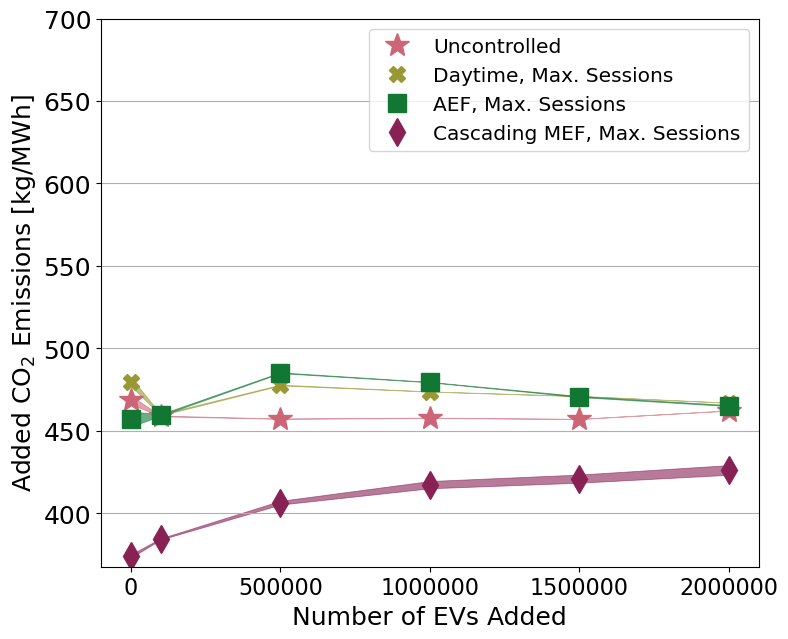

In [14]:
# run custom main plot - 2030
run_nums = [str(i) for i in range(15)]

added_EVs = [1000, 100000, 500000, 1000000, 1500000, 2000000]
fig1, axes1 = plt.subplots(figsize=(8,6.5))

#get daytime
result_dates = ['20231207']
results_gperkwh = results_gperkwh_fxn_avg(added_EVs, path_string_daytime_2030, run_nums, result_dates[0], current_year=2030)

#get regular AEF
results_gperkwh_aef = results_gperkwh_fxn_avg(added_EVs, path_string_aef_2030, run_nums, result_dates[0], current_year=2030)

#get cascade
results_cascade = results_gperkwh_fxn_avg(added_EVs, path_string_cascade_2030, run_nums, result_dates[0], current_year=2030)

multi_run_plot(added_EVs, results_gperkwh, results_gperkwh_aef,  results_cascade, fig1, axes1,  save_name='S3f_added_emissions_jan_30_max', to_plot = [0,1,3,5], legend_pos='upper right') 

In [15]:
## print table:
print('Number of Vehicles & Uncontrolled & Controlled: Daytime  \hline' + '\\'+ '\\')
print('1,000      & '+ str(np.round(results_gperkwh.uncontrolled[1000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[1000],1)) +'\\' + '\\')
print('100,000    & '+ str(np.round(results_gperkwh.uncontrolled[100000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[100000],1)) +'\\' + '\\')
print('500,000    & '+ str(np.round(results_gperkwh.uncontrolled[500000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[500000],1))+ '\\' + '\\')
print('1,000,000  & '+ str(np.round(results_gperkwh.uncontrolled[1000000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[1000000],1)) +'\\' + '\\')
print('1,500,000  & '+ str(np.round(results_gperkwh.uncontrolled[1500000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[1500000],1))+ '\\' + '\\')
print('2,000,000  & '+ str(np.round(results_gperkwh.uncontrolled[2000000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[2000000],1))  +'\\' + '\\')

Number of Vehicles & Uncontrolled & Controlled: Daytime  \hline\\
1,000      & 468.7 & 479.7\\
100,000    & 459.1 & 459.8\\
500,000    & 457.4 & 477.8\\
1,000,000  & 457.9 & 473.9\\
1,500,000  & 457.3 & 471.1\\
2,000,000  & 462.4 & 467.1\\


# g

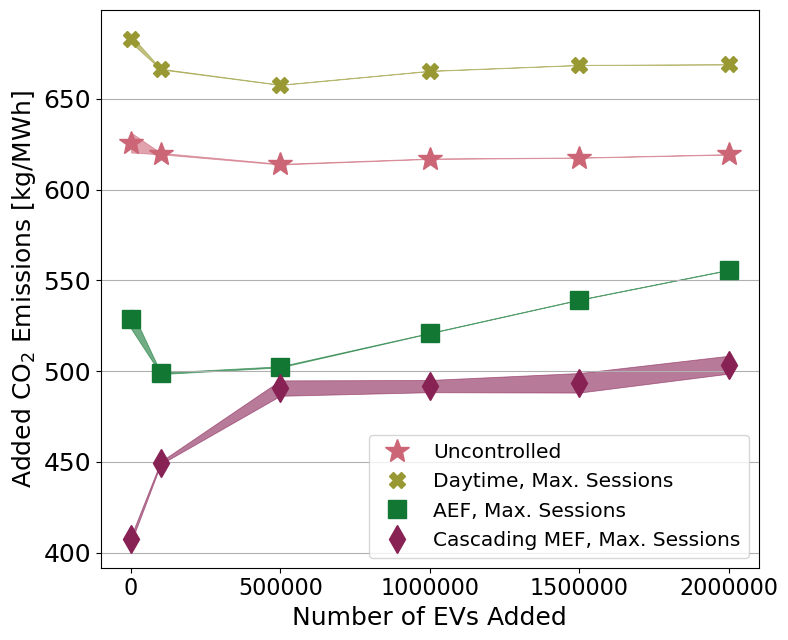

In [16]:
#run custom added emissions plot

run_nums = [str(i) for i in range(15)]

added_EVs = [1000,100000,500000, 1000000, 1500000, 2000000]
fig1, axes1 = plt.subplots(figsize=(8,6.5))

result_dates = ['20231207']
#get daytime
results_gperkwh = results_gperkwh_fxn_avg(added_EVs, path_string_daytime, run_nums, result_dates[0], month=7)

#get regular AEF
results_gperkwh_aef = results_gperkwh_fxn_avg(added_EVs, path_string_aef, run_nums, result_dates[0], month=7)

#get cascade
results_cascade = results_gperkwh_fxn_avg(added_EVs, path_string_cascade, run_nums, result_dates[0], month=7)

multi_run_plot(added_EVs, results_gperkwh, results_gperkwh_aef,  results_cascade, fig1, axes1,  save_name='S3g_added_emissions_jul_20_max', to_plot = [0,1,3,5], max_lim=675) 

In [17]:
## print table:
print('Number of Vehicles & Uncontrolled & Controlled: Daytime  \hline' + '\\'+ '\\')
print('1,000      & '+ str(np.round(results_gperkwh.uncontrolled[1000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[1000],1)) +'\\' + '\\')
print('100,000    & '+ str(np.round(results_gperkwh.uncontrolled[100000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[100000],1)) +'\\' + '\\')
print('500,000    & '+ str(np.round(results_gperkwh.uncontrolled[500000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[500000],1))+ '\\' + '\\')
print('1,000,000  & '+ str(np.round(results_gperkwh.uncontrolled[1000000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[1000000],1)) +'\\' + '\\')
print('1,500,000  & '+ str(np.round(results_gperkwh.uncontrolled[1500000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[1500000],1))+ '\\' + '\\')
print('2,000,000  & '+ str(np.round(results_gperkwh.uncontrolled[2000000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[2000000],1))  +'\\' + '\\')

Number of Vehicles & Uncontrolled & Controlled: Daytime  \hline\\
1,000      & 625.8 & 682.9\\
100,000    & 619.8 & 666.3\\
500,000    & 614.0 & 657.7\\
1,000,000  & 617.0 & 665.3\\
1,500,000  & 617.6 & 668.6\\
2,000,000  & 619.4 & 668.9\\


# h

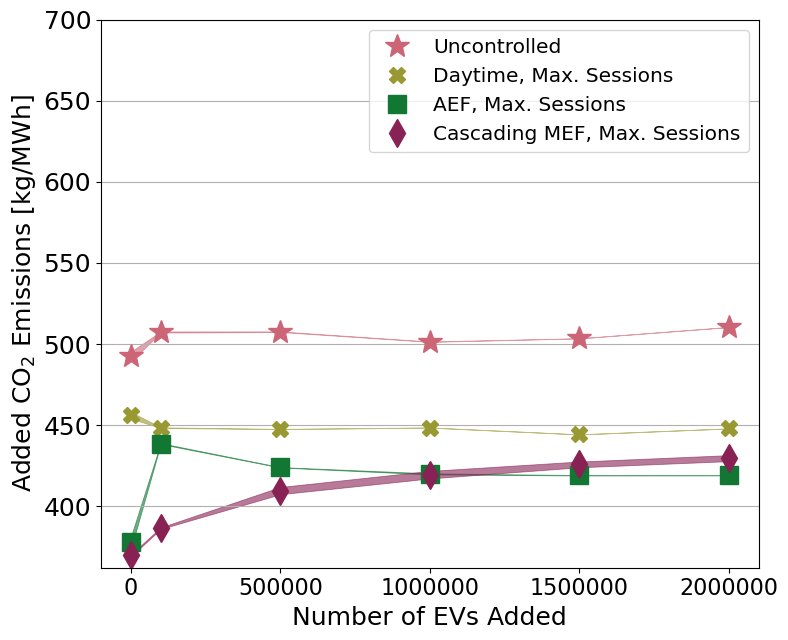

In [18]:
# run custom main plot - 2030
run_nums = [str(i) for i in range(15)]

added_EVs = [1000, 100000, 500000, 1000000, 1500000, 2000000]
fig1, axes1 = plt.subplots(figsize=(8,6.5))

#get daytime
result_dates = ['20231207']
results_gperkwh = results_gperkwh_fxn_avg(added_EVs, path_string_daytime_2030, run_nums, result_dates[0], current_year=2030, month=7)

#get regular AEF
results_gperkwh_aef = results_gperkwh_fxn_avg(added_EVs, path_string_aef_2030, run_nums, result_dates[0], current_year=2030, month=7)

#get cascade
results_cascade = results_gperkwh_fxn_avg(added_EVs, path_string_cascade_2030, run_nums, result_dates[0], current_year=2030, month=7)

multi_run_plot(added_EVs, results_gperkwh, results_gperkwh_aef, results_cascade, fig1, axes1, save_name='S3h_added_emissions_jul_30_max', to_plot = [0,1,3,5], legend_pos='upper right') 

In [19]:
## print table:
print('Number of Vehicles & Uncontrolled & Controlled: Daytime  \hline' + '\\'+ '\\')
print('1,000      & '+ str(np.round(results_gperkwh.uncontrolled[1000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[1000],1)) +'\\' + '\\')
print('100,000    & '+ str(np.round(results_gperkwh.uncontrolled[100000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[100000],1)) +'\\' + '\\')
print('500,000    & '+ str(np.round(results_gperkwh.uncontrolled[500000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[500000],1))+ '\\' + '\\')
print('1,000,000  & '+ str(np.round(results_gperkwh.uncontrolled[1000000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[1000000],1)) +'\\' + '\\')
print('1,500,000  & '+ str(np.round(results_gperkwh.uncontrolled[1500000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[1500000],1))+ '\\' + '\\')
print('2,000,000  & '+ str(np.round(results_gperkwh.uncontrolled[2000000],1))  +' & ' + str(np.round(results_gperkwh.varying_access[2000000],1))  +'\\' + '\\')

Number of Vehicles & Uncontrolled & Controlled: Daytime  \hline\\
1,000      & 492.5 & 456.1\\
100,000    & 507.5 & 448.5\\
500,000    & 507.7 & 447.7\\
1,000,000  & 501.5 & 448.6\\
1,500,000  & 503.6 & 444.4\\
2,000,000  & 510.5 & 448.1\\
